In [10]:
### src/data_loader.py
import yfinance as yf
import pandas as pd

def download_stock_data(symbol: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(symbol, start=start, end=end)
    df.columns = df.columns.get_level_values(0)
    df.reset_index(inplace=True)
    return df


### src/feature_engineering.py
import pandas as pd
import numpy as np

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df['Daily Returns'] = df['Close'].pct_change()
    df['Price Range'] = df['High'] - df['Low']
    df['Range %'] = df['Price Range'] / df['Close'] * 100
    df['Cumulative Return'] = (1 + df['Daily Returns']).cumprod()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA100'] = df['Close'].rolling(window=100).mean()
    df['StdDev5'] = df['Close'].rolling(window=5).std()
    df['StdDev10'] = df['Close'].rolling(window=10).std()
    df['Lag_1'] = df['Close'].shift(1)
    df['Lag_2'] = df['Close'].shift(2)
    df['Lag_10'] = df['Close'].shift(10)
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Weekday'] = df['Date'].dt.weekday
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Mid'] = rolling_mean
    df['Bollinger_Upper'] = rolling_mean + (2 * rolling_std)
    df['Bollinger_Lower'] = rolling_mean - (2 * rolling_std)
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    
    delta = df['Close'].diff()
    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    # Calculate the average gain and loss using exponential moving average (EMA is smoother than SMA)
    avg_gain = gain.rolling(window=14, min_periods=14).mean()
    avg_loss = loss.rolling(window=14, min_periods=14).mean()
    # Prevent division by zero
    rs = avg_gain / avg_loss.replace(0, np.nan)
    # Compute RSI
    df['RSI'] = 100 - (100 / (1 + rs))

    # Optional: fill or drop NaN if needed
    df.dropna(subset=['RSI'], inplace=True)
    df.dropna(inplace=True)
    return df

In [11]:
df = download_stock_data('RELIANCE.NS','2015-01-01','2025-01-01')
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2015-01-01,197.333191,198.244408,196.388638,196.977606,2963643
1,2015-01-02,196.810913,199.144515,196.533112,197.377642,7331366
2,2015-01-05,194.655121,197.999948,194.266185,196.688683,10103941
3,2015-01-06,185.820801,194.021722,184.909584,193.354985,18627980
4,2015-01-07,189.865692,190.865805,186.020823,186.043047,20720312


In [12]:
add_features(df = df)

Price,Date,Close,High,Low,Open,Volume,Daily Returns,Price Range,Range %,Cumulative Return,...,Month,Weekday,MACD,Signal_Line,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,EMA_10,EMA_20,RSI
99,2015-05-29,194.910706,197.010940,194.043937,195.555219,29277517,0.001370,2.967003,1.522237,0.987724,...,5,4,0.435442,0.882973,197.127064,201.981200,192.272928,196.850553,196.729339,43.210279
100,2015-06-01,200.522446,201.111413,195.132959,195.577455,19594976,0.028791,5.978455,2.981439,1.016162,...,6,0,0.691875,0.844753,197.252634,202.327948,192.177320,197.518170,197.090587,62.195610
101,2015-06-02,199.722366,204.200637,198.122188,201.300320,20178960,-0.003990,6.078448,3.043449,1.012107,...,6,1,0.821076,0.840018,197.324864,202.501710,192.148019,197.918933,197.341233,55.430906
102,2015-06-03,199.211182,202.344865,197.466547,199.800134,15546279,-0.002559,4.878318,2.448817,1.009517,...,6,2,0.872166,0.846447,197.503773,202.681750,192.325796,198.153887,197.519323,57.553086
103,2015-06-04,202.844940,203.622798,198.366655,200.955834,15931395,0.018241,5.256143,2.591212,1.027931,...,6,3,1.192127,0.915583,197.969937,203.314467,192.625408,199.006806,198.026525,64.650355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,2024-12-24,1222.750000,1233.550049,1221.000000,1222.300049,6734917,0.000368,12.550049,1.026379,6.196373,...,12,1,-22.294034,-16.925558,1273.640009,1343.562596,1203.717421,1243.258441,1261.574919,26.460945
2463,2024-12-26,1216.550049,1227.699951,1214.250000,1224.250000,10016178,-0.005070,13.449951,1.105581,6.164954,...,12,3,-23.141476,-18.168742,1269.807513,1343.515988,1196.099039,1238.402370,1257.286836,20.062379
2464,2024-12-27,1221.050049,1227.900024,1217.000000,1218.300049,7000397,0.003699,10.900024,0.892676,6.187758,...,12,4,-23.182732,-19.171540,1267.320013,1344.178069,1190.461958,1235.247402,1253.835714,23.413585
2465,2024-12-30,1210.699951,1223.199951,1208.099976,1216.400024,8818766,-0.008476,15.099976,1.247210,6.135308,...,12,0,-23.776512,-20.092534,1263.245013,1343.131408,1183.358619,1230.784230,1249.727546,24.276520


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def eda_summary(df: pd.DataFrame, stock_name: str):
    print("\nData Summary:\n", df.describe())
    print("\nMissing Values:\n", df.isnull().sum())
    
    corr = df.corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Correlation Heatmap for {stock_name}")
    plt.tight_layout()
    plt.savefig(f"C://GITHUB CODES//stock-predictor-ml//reports/{stock_name}_correlation_heatmap.png")
    print(f"Correlation heatmap saved to reports/{stock_name}_correlation_heatmap.png")



Data Summary:
 Price                           Date        Close         High          Low  \
count                           2368  2368.000000  2368.000000  2368.000000   
mean   2020-03-14 18:07:54.324324352   760.864036   769.168948   753.218583   
min              2015-05-29 00:00:00   184.365082   186.887583   181.798127   
25%              2017-10-22 00:00:00   397.109756   401.964317   392.530462   
50%              2020-03-18 12:00:00   684.445312   695.535469   681.359080   
75%              2022-08-03 06:00:00  1140.630981  1151.405029  1130.836358   
max              2024-12-31 00:00:00  1595.484985  1603.358288  1580.137072   
std                              NaN   414.273180   418.100762   410.771413   

Price         Open        Volume  Daily Returns  Price Range      Range %  \
count  2368.000000  2.368000e+03    2368.000000  2368.000000  2368.000000   
mean    761.399432  1.854320e+07       0.000927    15.950365     2.163238   
min     184.465100  1.705656e+06      -0.

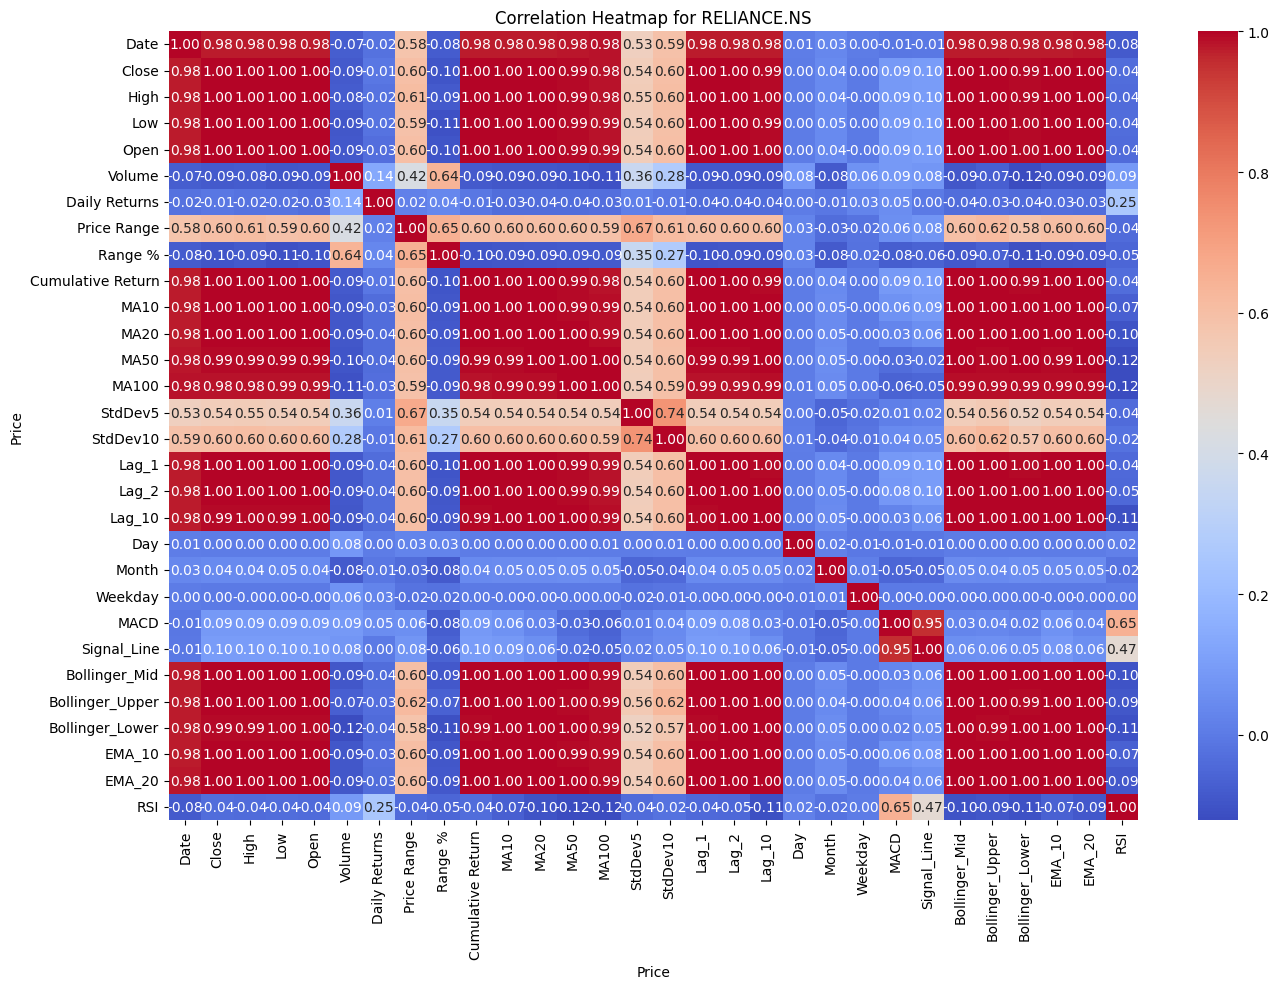

In [14]:
eda_summary(df, 'RELIANCE.NS')

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def select_features_by_correlation(df: pd.DataFrame, threshold: float = 0.75) -> list:
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return [col for col in df.columns if col not in to_drop]

def calculate_vif(X: pd.DataFrame) -> pd.DataFrame:
    X = X.select_dtypes(include=[np.number]).dropna()
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) if X.values[:, i].std() > 0 else np.inf for i in range(X.shape[1])]
    return vif_data[vif_data['VIF'] < 10]['Feature'].tolist()

In [16]:
select_features_by_correlation(df, threshold=0.75)

['Date',
 'Volume',
 'Daily Returns',
 'Price Range',
 'Range %',
 'StdDev5',
 'StdDev10',
 'Day',
 'Month',
 'Weekday',
 'MACD',
 'RSI']

In [17]:
calculate_vif(df)

c:\GITHUB CODES\stock-predictor-ml\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


['Volume', 'Daily Returns', 'StdDev5', 'Day', 'Month', 'Weekday']

In [18]:
import pandas as pd
import numpy as np
import joblib
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

def select_features_by_correlation(df: pd.DataFrame, threshold: float = 0.75) -> list:
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return [col for col in df.columns if col not in to_drop]

def train_and_evaluate(df: pd.DataFrame, stock_name: str):
    all_features = df.drop(columns=['Close', 'Date']).select_dtypes(include=[np.number])
    filtered_features = select_features_by_correlation(all_features, threshold=0.75)
    #filtered_features = calculate_vif(df[filtered_features])

    X = df[filtered_features]
    y = df['Close']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())
    ])

    param_grid = {
        'svr__C': [0.1, 1, 10],
        'svr__epsilon': [0.1, 1],
        'svr__kernel': ['linear']
    }

    grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

    model_path = f"C://GITHUB CODES//stock-predictor-ml//models/{stock_name}_svr_model.pkl"
    joblib.dump(best_model, model_path)
    print(f"Model saved to {model_path}")


In [19]:
train_and_evaluate(df, 'RELIANCE.NS')

Best Parameters: {'svr__C': 10, 'svr__epsilon': 1, 'svr__kernel': 'linear'}
Test RMSE: 5.53
R² Score: 0.9987
Model saved to C://GITHUB CODES//stock-predictor-ml//models/RELIANCE.NS_svr_model.pkl


In [20]:
### src/train_model.py
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

In [21]:
def adjusted_r2_score(r2: float, n: int, k: int) -> float:
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def select_features_by_correlation(df: pd.DataFrame, threshold: float = 0.75) -> list:
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return [col for col in df.columns if col not in to_drop]

In [22]:
def train_multiple_models(df: pd.DataFrame, stock_name: str):
    all_features = df.drop(columns=['Close', 'Date']).select_dtypes(include=[np.number])
    filtered_features = select_features_by_correlation(all_features, threshold=0.75)

    X = df[filtered_features]
    y = df['Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.9),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='linear', C=10, epsilon=1),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    }

    results = []
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        adj_r2 = adjusted_r2_score(r2, X_test.shape[0], X_test.shape[1])
        results.append((name, rmse, r2, adj_r2))
        model_path = f"C://GITHUB CODES//stock-predictor-ml//models/{stock_name}_{name.replace(' ', '_').lower()}.pkl"
        joblib.dump(pipeline, model_path)
    
    print("\nModel Comparison Results:")
    for name, rmse, r2, adj_r2 in sorted(results, key=lambda x: x[1]):  
        print(f"{name}: RMSE = {rmse:.2f}, R² = {r2:.4f}, Adjusted R² = {adj_r2:.4f}")


In [23]:
train_multiple_models(df, 'RELIANCE.NS')


Model Comparison Results:
Linear Regression: RMSE = 5.29, R² = 0.9988, Adjusted R² = 0.9988
Ridge Regression: RMSE = 5.47, R² = 0.9987, Adjusted R² = 0.9987
Lasso Regression: RMSE = 5.49, R² = 0.9987, Adjusted R² = 0.9987
SVR: RMSE = 5.53, R² = 0.9987, Adjusted R² = 0.9986
ElasticNet: RMSE = 19.35, R² = 0.9838, Adjusted R² = 0.9834
Random Forest: RMSE = 121.13, R² = 0.3665, Adjusted R² = 0.3500
XGBoost: RMSE = 126.68, R² = 0.3071, Adjusted R² = 0.2890


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_residuals(y_true, y_pred, model_name, stock_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {model_name}")
    plt.tight_layout()
    path = f"C://GITHUB CODES//stock-predictor-ml//reports/{stock_name}_{model_name}_residuals.png"
    plt.savefig(path)
    plt.close()
    print(f"✅ Saved residual plot: {path}")

def plot_feature_importance(model, feature_names, model_name, stock_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importance", y="Feature", data=df)
        plt.title(f"Feature Importance - {model_name}")
        plt.tight_layout()
        path = f"C://GITHUB CODES//stock-predictor-ml//reports/{stock_name}_{model_name}_feature_importance.png"
        plt.savefig(path)
        plt.close()
        print(f"✅ Saved feature importance chart: {path}")


In [30]:
plot_feature_importance(model=LinearRegression(), feature_names='filtered_features', model_name='Linear Regression',stock_name='HCL.NS')